# **Housing Price Prediction**

## **Library Import**

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

import os
import pickle

from feature_engine.selection import DropCorrelatedFeatures
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
from sklearn.feature_selection import RFE, RFECV
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import sklearn.metrics as met
from sklearn import metrics

## **Data Import**

In [6]:
house_df = pd.read_csv("data/kc_house_data_train.csv", index_col=0)

In [7]:
test_house_df = pd.read_csv("data/kc_house_data_test_features.csv", index_col=0)

## **Data structure and Description**

In [8]:
#preview the dataset
house_df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
1,7974200820,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
2,7701450110,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
3,9522300010,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
4,9510861140,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050


In [9]:
#number of rows and columns of house_data
print(f'house_data has {len(house_df)} rows and {len(house_df.columns)} columns')

house_data has 17290 rows and 21 columns


In [10]:
#number of rows and columns of house_data
print(f'test_data has {len(test_house_df)} rows and {len(test_house_df.columns)} columns')

test_data has 4323 rows and 20 columns


In [11]:
#summary of house_data dataframe
house_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17290 entries, 0 to 17289
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             17290 non-null  int64  
 1   date           17290 non-null  object 
 2   price          17290 non-null  float64
 3   bedrooms       17290 non-null  int64  
 4   bathrooms      17290 non-null  float64
 5   sqft_living    17290 non-null  int64  
 6   sqft_lot       17290 non-null  int64  
 7   floors         17290 non-null  float64
 8   waterfront     17290 non-null  int64  
 9   view           17290 non-null  int64  
 10  condition      17290 non-null  int64  
 11  grade          17290 non-null  int64  
 12  sqft_above     17290 non-null  int64  
 13  sqft_basement  17290 non-null  int64  
 14  yr_built       17290 non-null  int64  
 15  yr_renovated   17290 non-null  int64  
 16  zipcode        17290 non-null  int64  
 17  lat            17290 non-null  float64
 18  long       

In [12]:
#summary statistics of house_data
house_df.drop('id', axis=1).describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,1.729000e+04,17290.000000,17290.000000,17290.000000,1.729000e+04,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000
mean,5.407395e+05,3.372470,2.111943,2081.464604,1.524340e+04,1.490312,0.007981,0.238519,3.408502,7.654425,1789.306015,292.158589,1970.792019,83.806304,98078.193175,47.560058,-122.214258,1987.986698,12873.475824
std,3.733190e+05,0.939346,0.770476,920.018539,4.230462e+04,0.538909,0.088985,0.775229,0.651296,1.174718,829.265107,443.151874,29.343516,400.329376,53.607949,0.138412,0.140857,684.802635,27227.437583
min,7.500000e+04,0.000000,0.000000,290.000000,5.720000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,659.000000
25%,3.210000e+05,3.000000,1.500000,1430.000000,5.081250e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1951.000000,0.000000,98033.000000,47.471200,-122.329000,1490.000000,5111.250000
50%,4.500000e+05,3.000000,2.250000,1920.000000,7.642000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1974.000000,0.000000,98065.000000,47.571600,-122.230000,1840.000000,7622.500000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.072575e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2214.500000,560.000000,1996.000000,0.000000,98118.000000,47.677900,-122.126000,2360.000000,10101.750000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,858132.000000


In [13]:
# unique values of some columns
for column in ['bedrooms', 'bathrooms', 'floors',  'waterfront', 'view', 'yr_renovated','zipcode']:
    print(f'{column.upper()}:')
    print(house_df[column].value_counts())
    print('********************************')

BEDROOMS:
bedrooms
3     7864
4     5488
2     2204
5     1283
6      229
1      160
7       30
0       12
8       10
9        5
10       3
11       1
33       1
Name: count, dtype: int64
********************************
BATHROOMS:
bathrooms
2.50    4322
1.00    3100
1.75    2431
2.25    1666
2.00    1549
1.50    1168
2.75     896
3.00     592
3.50     591
3.25     455
3.75     135
4.00     107
4.50      76
4.25      64
0.75      52
5.00      17
4.75      16
5.25      11
0.00       8
5.50       7
6.00       6
1.25       6
5.75       3
0.50       3
6.75       2
8.00       2
6.25       2
6.50       1
7.50       1
7.75       1
Name: count, dtype: int64
********************************
FLOORS:
floors
1.0    8606
2.0    6538
1.5    1524
3.0     475
2.5     140
3.5       7
Name: count, dtype: int64
********************************
WATERFRONT:
waterfront
0    17152
1      138
Name: count, dtype: int64
********************************
VIEW:
view
0    15571
2      775
3      410
4      270
1   

## **Data Analysis**





### **Property Value by Zipcode**

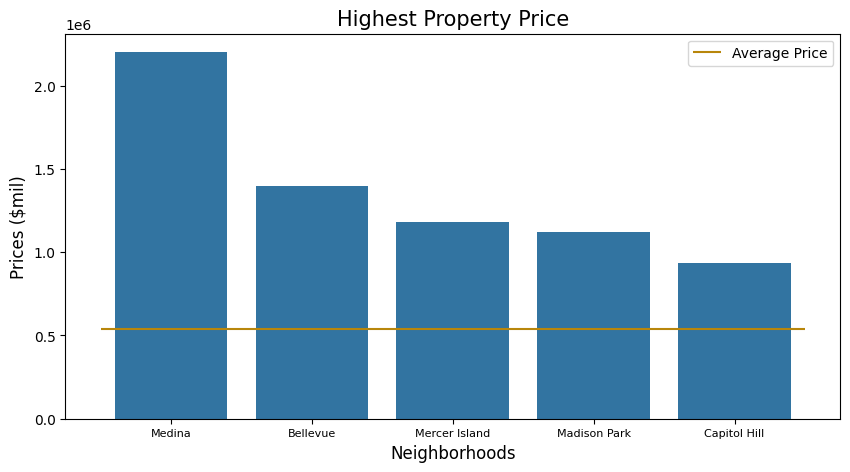

In [14]:
#property values by zipcode calculation
kc_top5_price = house_df.groupby("zipcode")["price"].mean().sort_values(ascending = False)[:5]
kc_mean_price = house_df.price.mean()

#top5 neighborhood label for plot
area_labels = ["Medina", "Bellevue", "Mercer Island",
               "Madison Park", "Capitol Hill"]

#plotting the data
plt.subplots(figsize=(10,5))
sns.barplot(x=kc_top5_price.index, y=kc_top5_price, order=kc_top5_price.index)
plt.xticks(np.arange(5), area_labels, size=8)

#plot average price horizontal line
plt.hlines(kc_mean_price, -.5 ,4.5, colors="darkgoldenrod", label="Average Price")

#prettify graph
plt.xlabel("Neighborhoods", size=12)
plt.ylabel("Prices ($mil)", size=12)
plt.title("Highest Property Price", size=15)
plt.legend() #show legend


plt.show()

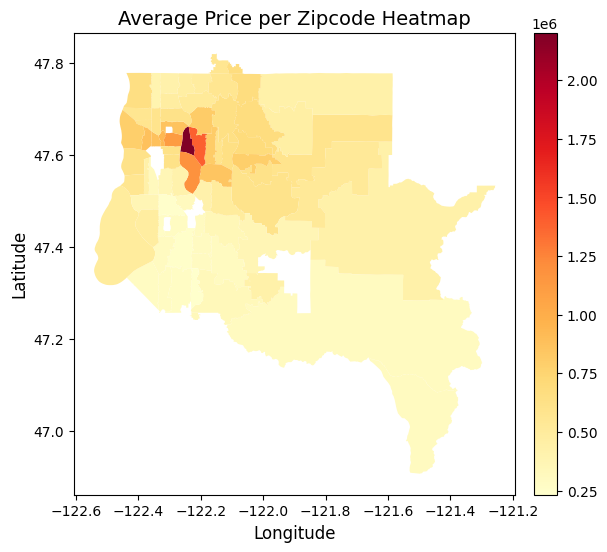

In [15]:
#shapefile data setup
king_county = gpd.read_file("data/Zipcodes_for_King_County_and_Surrounding_Area___zipcode_area.shp")

#kc_df price setup
zip_price = house_df.groupby("zipcode").price.mean()

king_county["zipcode"] = king_county["ZIP"] #set up column for merge

#plotting data setup
zip_plot_df = king_county.join(zip_price, on="zipcode", how="inner")

#plot setup
fig, ax = plt.subplots(figsize=(12,6))
zip_plot_df.plot(column="price", cmap="YlOrRd", ax=ax)

#set up colorbar
color_bar = plt.cm.ScalarMappable(cmap="YlOrRd", norm=plt.Normalize(vmin=zip_price.min(), vmax=zip_price.max()))
cbar = fig.colorbar(color_bar, fraction=0.03, pad=0.02, ax=fig.gca())

#set figure limit to zoom in on select neighborhoods
ax.set_ylabel("Latitude", size=12)
ax.set_xlabel("Longitude", size=12)


plt.title("Average Price per Zipcode Heatmap", size=14)

plt.show();

### **Distribution of house prices**

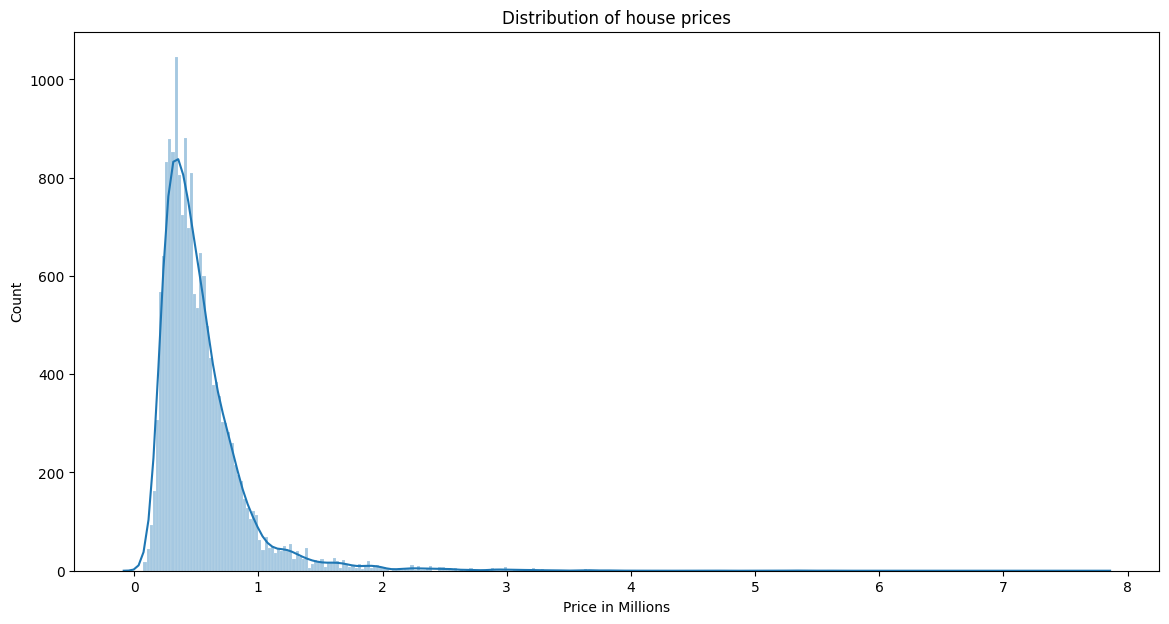

In [16]:
# Distribution of house prices
fig, ax = plt.subplots(figsize=(14,7))
sns.histplot(house_df['price']/1000000, kde=True, kde_kws=dict(cut=3),
             alpha=.4, edgecolor=(1, 1, 1, .4), ax=ax)
ax.set_title('Distribution of house prices')
ax.set_xlabel('Price in Millions');

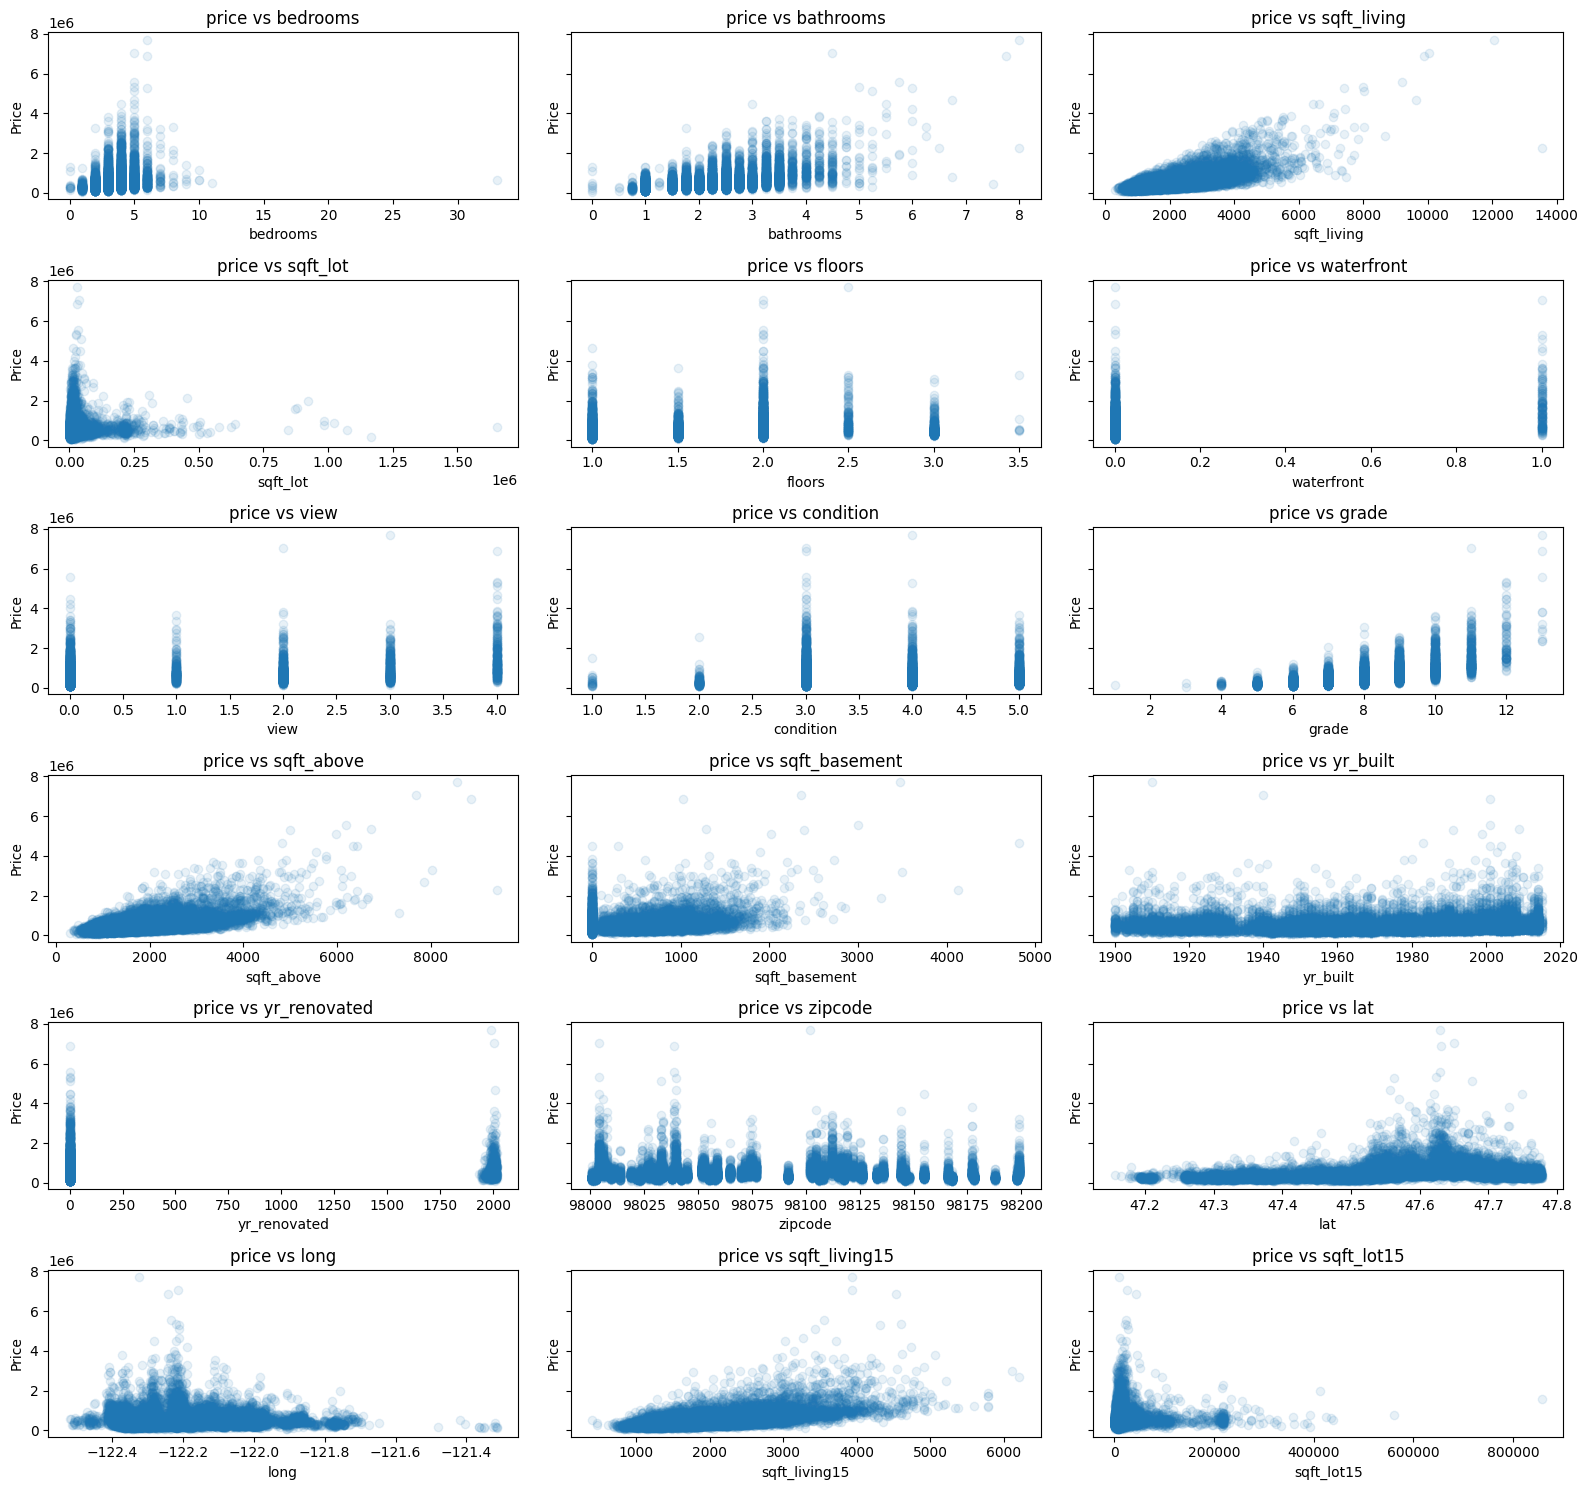

In [17]:
#scatter plots of price vs other columns
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(16,15), sharey=True )

for ax, column in zip(axes.flatten(), house_df.columns[3:]):
    ax.scatter(house_df[column], house_df['price'], label=column, alpha=.1)
    ax.set_title(f'price vs {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Price')
fig.tight_layout()

### **bedrooms,grade**

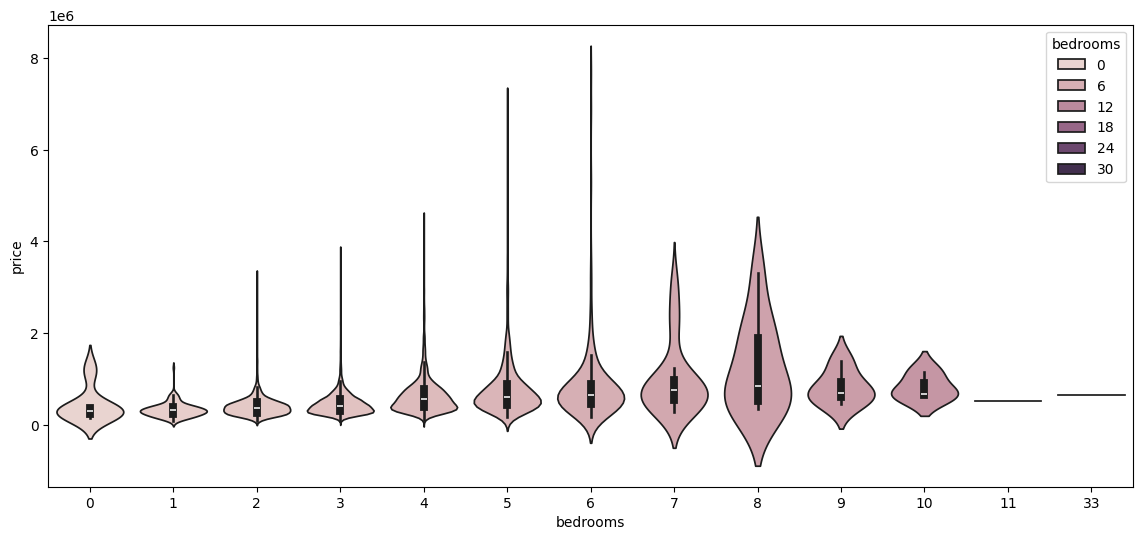

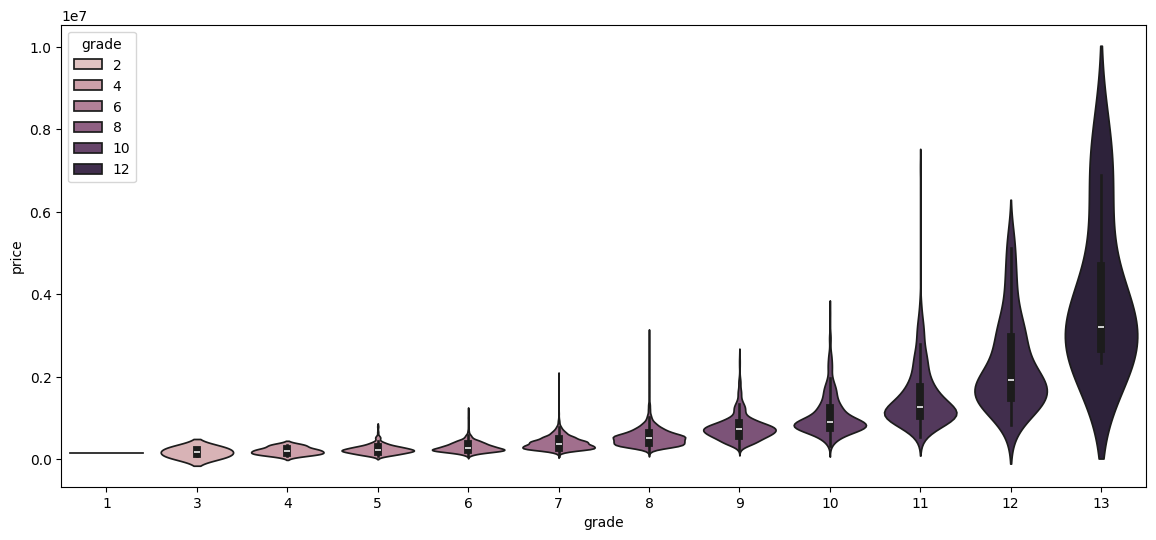

In [18]:
def violin_plot(df, var):
  data = pd.concat([df['price'], df[var]], axis=1)
  f, ax = plt.subplots(figsize=(14, 6))
  fig = sns.violinplot(x=var, y="price", data=data, hue=var)



violin_plot(house_df,'bedrooms')
violin_plot(house_df,'grade')

### **bathroom**

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


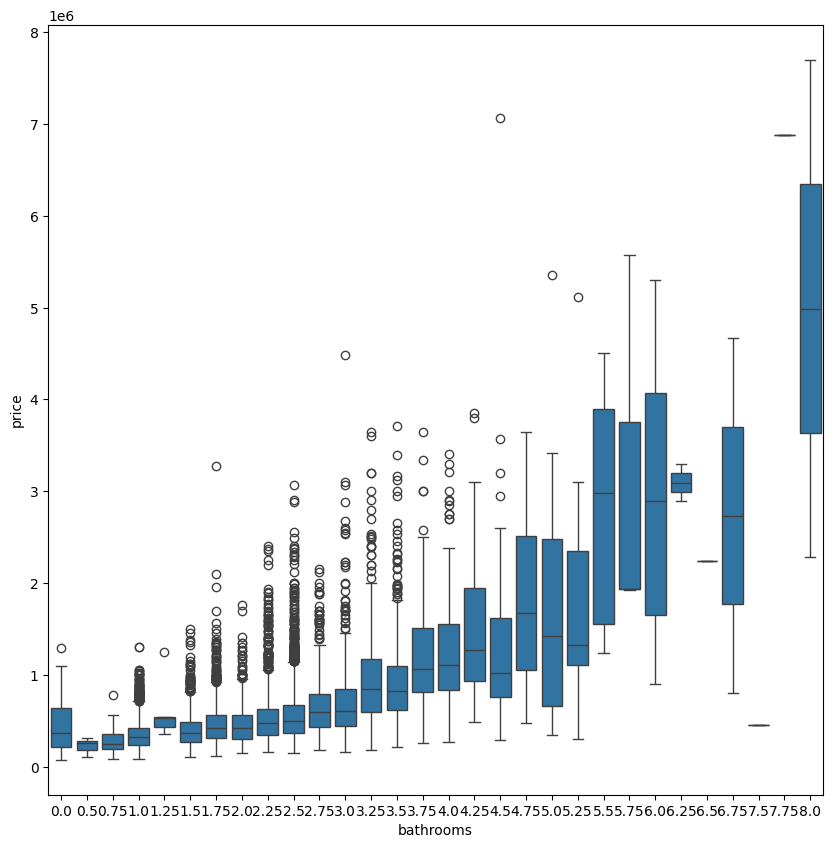

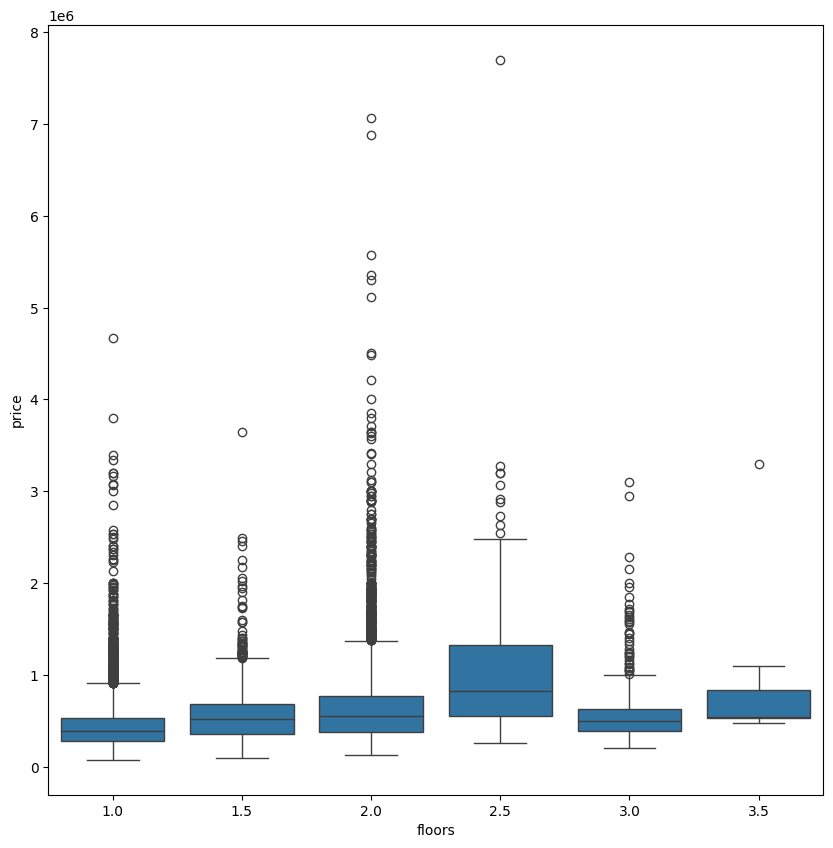

In [19]:
var = 'bathrooms'
def box_plot(df, var):
  data = pd.concat([df['price'], df[var]], axis=1)
  f, ax = plt.subplots(figsize=(10, 10))
  fig = sns.boxplot(x=var, y="price", data=data)

box_plot(house_df,'bathrooms')
box_plot(house_df,'floors')

In [20]:
continuous = ['sqft_living', 'sqft_lot',
         'sqft_above', 'sqft_basement',
       'sqft_living15','view', 'sqft_lot15']

categorical = ['waterfront','condition','grade',
               'bedrooms','floors']

#price, yr_built, yr_renovated, zipcode, lat, long

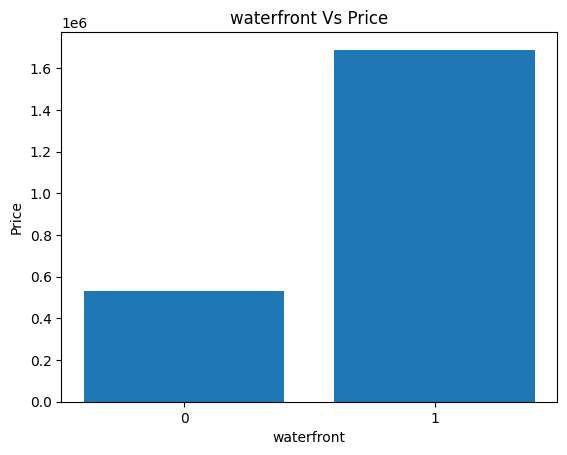

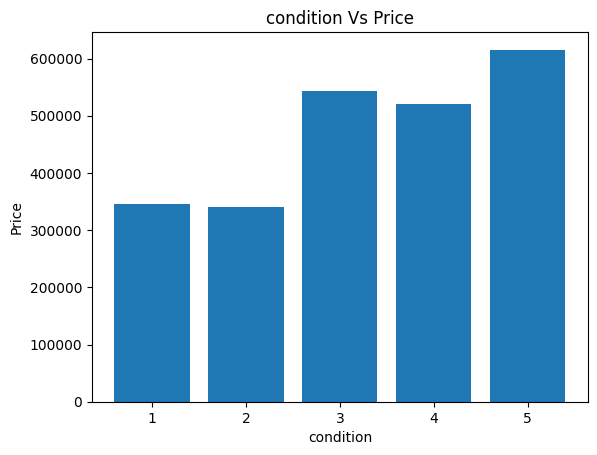

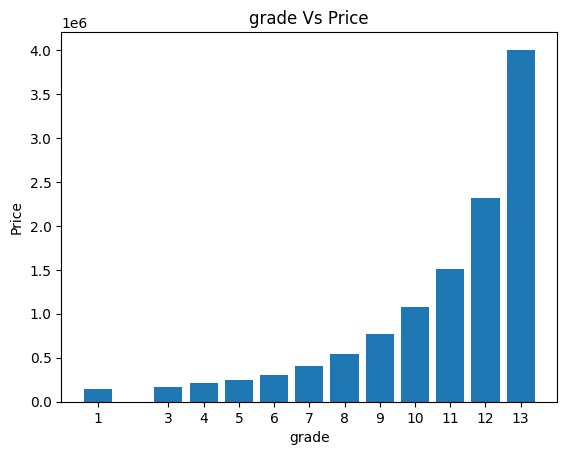

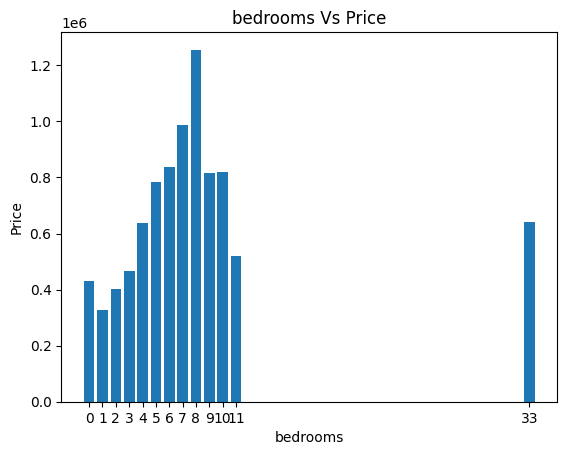

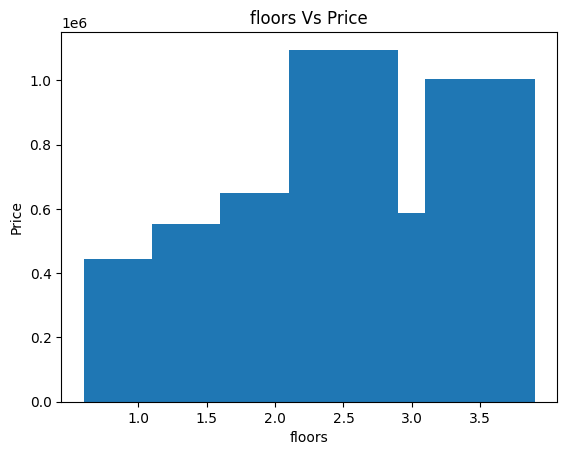

In [21]:
for x in categorical:
    group = house_df.groupby(x).price.mean()
    plt.figure()
    plt.bar(group.index,group.values)
    plt.title(f'{x} Vs Price')
    plt.ylabel('Price')
    plt.xlabel(x)
    plt.xticks(group.index)
    plt.show()

## **Data cleaning**

In [22]:
def check_null(house_data):

  #check for missing values
  #each column
  null_count = house_df.isnull().sum()

  #total
  total_null = null_count.sum()
  print(f"There are total {total_null} null values in the data")

  # replace missing values with 0
  house_data = house_data.fillna(0.0)

  return(house_data)

In [23]:
def remove_duplicate(house_df):

  # check for duplicates based on id
  print(house_df.duplicated(subset = ['id']).value_counts())

  #display duplicated values
  duplicates = house_df[house_df.duplicated(subset = ['id'])]

  # dropping ALL duplicate values
  house_df.drop_duplicates(subset="id", keep=False, inplace=True)

  return(house_df)

In [24]:
def scale_data(X):
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X

## **Feature Engineering**

In [25]:
def feature_engineering(house_df, flag):
      
  # extract the year the house  was sold from the date column
  #date -> Date year house was sold
  house_df['year_sold'] = pd.DatetimeIndex(house_df['date']).year

  # create a column for the house age
  #yr_sold - Year when house was built
  house_df['house_age'] = house_df['year_sold'] - house_df['yr_built']
  # shape of records with house_age of -1
  house_df[house_df['house_age'] == -1].shape

  '''
  The 7 records above contain wrong values, since a house cannot be sold a year before it was built. These records are therefore dropped.
  Columns for drop year_sold, yr_built and date are dropped as they are no longer required.
  '''


  #drop rows with age of -1
  house_df = house_df[house_df['house_age'] >= 0].copy()
  # check if the rows have been dropped
  house_df[house_df['house_age'] == -1].shape

  house_df['month_sold'] = pd.DatetimeIndex(house_df['date']).month
  #Sale season based on month
  house_df["sale_season"] = house_df.month_sold.apply(lambda x: x//3.1 + 1)

  #Renovation
  #this feature can be updated to a categorical feature
  #yr_renovated - Year when house was renovated
  house_df["renovated"] = house_df.yr_renovated.apply(lambda x: 1 if x > 0 else 0)
  #Renovation Age, so this feature may provide a negatively correlated feature
  house_df["renovation_age"] = house_df.yr_renovated.apply(lambda x: 2020-x if x > 0 else 0)

  #unique bedroom values
  house_df.bedrooms.unique()
  # drop record with 33 bedrooms
  house_df = house_df[house_df['bedrooms'] <= 11]
  #Family House
  house_df["family_house"] = house_df.bedrooms.apply(lambda x: 1 if x > 2 else 0)

  #Basement
  #The idea of this feature is similar to the renovation.
  house_df["basement"] = house_df.sqft_basement.apply(lambda x: 1 if x != 0 else 0)

  drop_features = ['id', 'date','zipcode','lat', 'long','year_sold', 'yr_built', 'yr_renovated','month_sold']

  # drop year_sold, yr_built and date columns
  house_df = house_df.drop(drop_features  , axis=1)

  print("len used feautures is:", len(house_df.columns))

  if(flag == 1):
    tr = DropCorrelatedFeatures(variables=None, method='pearson', threshold=0.75)
    Xt = tr.fit_transform(house_df)
    tr.correlated_feature_sets_
    corr_features = list(tr.features_to_drop_)
    house_df = house_df.drop(corr_features , axis=1)
    return(house_df, corr_features)
  else:
    return(house_df)

## **learn model**

In [26]:
def apply_rfe(x_train, y_train, x_test):
  rfe = RFE(estimator=LinearRegression(), step=1)
  rfe = rfe.fit(x_train, y_train)
  # visualize how the feature are ranked
  rfe_ranking = pd.DataFrame({"Model Features":x_train.columns, "Feature Ranking": rfe.ranking_})
  rank_check = rfe_ranking.sort_values(by="Feature Ranking")
  print(rank_check)

  x_train_rfe = rfe.transform(x_train)
  x_test_rfe = rfe.transform(x_test)

  return(x_train_rfe, x_test_rfe, rfe)

In [27]:
def learn_model(x_train, y_train):

    print('choose model:\n1.Linear Regression \n2.RandomForestRegressor \n3.SGDRegressor \n4.Ridge Regression ')
    mod_type = int(input())

    if(mod_type == 1):
      model = LinearRegression()
    elif(mod_type == 2):
      model = RandomForestRegressor()
    elif(mod_type == 3):
      model = SGDRegressor(penalty='l2', alpha=0.15)
    elif(mod_type == 4):
      model = Ridge(fit_intercept=True, alpha=.3)


    # Train the model using the training sets
    model.fit(x_train, y_train)

    # Predict the values using the model
    y_train_prediction = model.predict(x_train)

    print("Training data accuracy", model.score(x_train, y_train))

    return(model)

In [28]:
def predict(model, x_test, y_test):
  y_test_prediction = model.predict(x_test)
  print("Testing data accuracy",  model.score(x_test, y_test))
  return(y_test_prediction)

In [29]:
def evaluate(model, y , y_prediction):

  print("sqrt Mean Square Error: ", np.sqrt(metrics.mean_squared_error(y , y_prediction)))
  print("MAPE: Mean Absolute Percentage Error= ", met.mean_absolute_percentage_error(y , y_prediction))

  #print("coef ",  model.coef_)

## **plot model**

In [41]:
def plot_real_vs_predicted(y_pred,y_real):
    plt.plot(np.arange(len(y_pred)),y_pred,'o', label='predicted values')
    plt.plot(np.arange(len(y_real)),y_real, 'o',alpha=0.5, label='real values')
    plt.legend(loc='upper left', ncols=2)
    plt.show()
    return plt

## **implementation**

In [31]:
#train Data---------------------------------
house_data = check_null(house_df)
house_data = remove_duplicate(house_data)
house_data, corr_features = feature_engineering(house_data,1)

target = house_data["price"] #target column is the price column
data = house_data.drop('price' , axis=1)
#X = scale_data(data)

x1, x2, y_train, y_validation = train_test_split(data, target ,test_size=0.2, random_state=42)

There are total 0 null values in the data
False    17176
True       114
Name: count, dtype: int64
len used feautures is: 20


In [32]:
#test data-------------------------------------
test_data = check_null(test_house_df)
test_data = remove_duplicate(test_data)
test_data = feature_engineering(test_data,0)
test_data = test_data.drop(corr_features , axis=1)

There are total 0 null values in the data
False    4300
True       23
Name: count, dtype: int64
len used feautures is: 19


In [33]:
print('do you want apply Recursive Feature Elimination or not?\n 1.YES 2.NO')
choice = int(input())
if(choice == 1):
  x_train, x_validation, rfe_transform = apply_rfe(x1, y_train, x2)
  rfe_test_data = rfe_transform.transform(test_data)
else:
  x_train = x1
  x_validation = x2

while(True):
  print('continue? Y or N')
  st_input = input()
  if(st_input == 'Y' or st_input == 'y'):
    model = learn_model(x_train, y_train)
    y_validation_prediction = predict(model, x_validation, y_validation)
    evaluate(model, y_validation , y_validation_prediction)
  else:
    break;

do you want apply Recursive Feature Elimination or not?
 1.YES 2.NO
1
   Model Features  Feature Ranking
1       bathrooms                1
4      waterfront                1
5            view                1
6       condition                1
7           grade                1
12      renovated                1
13   family_house                1
14       basement                2
0        bedrooms                3
3          floors                4
11    sale_season                5
10      house_age                6
8   sqft_living15                7
9      sqft_lot15                8
2        sqft_lot                9
continue? Y or N
y
choose model:
1.Linear Regression 
2.RandomForestRegressor 
3.SGDRegressor 
4.Ridge Regression 
4
Training data accuracy 0.5497595028469826
Testing data accuracy 0.5643594518450039
sqrt Mean Square Error:  246851.40728684707
MAPE: Mean Absolute Percentage Error=  0.34321793622442026
continue? Y or N
n


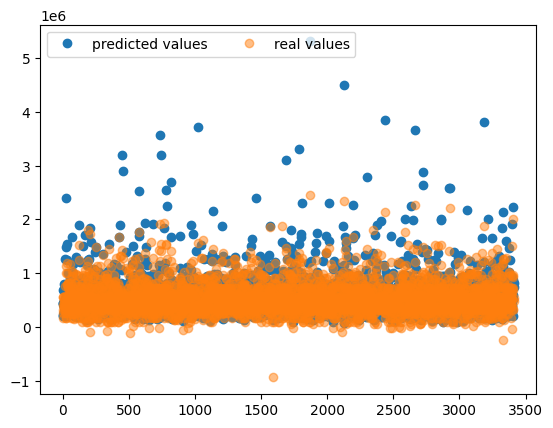

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

In [42]:
plot_real_vs_predicted(y_validation , y_validation_prediction)

In [35]:
if(choice == 1):
  price_prediction = model.predict(rfe_test_data)
else:
  price_prediction = model.predict(test_data)

In [36]:
price_prediction_df = pd.DataFrame({"price":price_prediction})
price_prediction_df.describe()

,price
count,4.272000e+03
mean,5.848957e+05
std,2.671987e+05
min,-9.301624e+05
25%,3.879662e+05
50%,5.611614e+05
75%,7.343567e+05
max,2.228350e+06
